##### hypothèses:
- Il n'y a pas de délai ni de fenêtre temporelle pour nos navires aux endroits visés.
- La date d'échéance, la durée du service et l'heure de disponibilité sont ignorées.
- Les navires partent toujours du dépôt et livre les marchandises.

In [32]:
import numpy as np
import random
from deap import base, creator, tools, algorithms, benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
import matplotlib.pyplot as plt

In [33]:
def initialize_map(p_inf, N):
    # create the map that we are trying to navigate.  I will do this randomly.
    # This will be of the form of a adjacency matrix... non symetrical
    
    # The initialization needs some tuning parameters.  One is the proportion of 0's in the final result
    
    the_map = np.zeros((N,N))
    
    for i in range(0, N):
        for j in range(0, N):
            if random.random() > p_inf:
                the_map[i][j] = round(random.uniform(0,50),2)
            else:
                the_map[i][j] = np.Inf

    return the_map

In [34]:
class Navire:
    def __init__(self, name, tonnage, coute, price):
        self.name = name
        self.tonnage = tonnage #tonnage en tonne
        self.coute = coute # coute en $ par jour
        self.price = price # le prix pour louer le navire


In [35]:
navires = [Navire("A", 27, 13.2, 1000),
           Navire("B", 32, 12.5, 1200),
           Navire("C", 48, 10.8, 1500),
           Navire("D", 60, 9.2, 1900)]

In [36]:
def distribuer_poids(commande, list_navire):
    genome_poids = [0, 0, 0, 0]
    available_indice = [i for i in range(len(list_navire))]
    checked_indice = []
    reste = commande
    
    for i in range(len(list_navire)):
        p = random.choice(available_indice)
        if p not in checked_indice:
            if list_navire[p] != 0:
                poids_max = list_navire[p]*navires[p].tonnage
                if poids_max < reste:
                    genome_poids[p] = list_navire[p]*navires[p].tonnage
                    reste = reste - genome_poids[p]
                else:
                    genome_poids[p] = reste
                    reste = reste - genome_poids[p]
            checked_indice.append(p)
            available_indice.pop(available_indice.index(p))
            
    return genome_poids

In [37]:
def create_member(tonnage, depart, arrivee, cities):
    genome_road = []
    genome_navire = [0 for _ in range(len(navires))]
    genome_quantity = []
    
    #choix de navire
    nombre_max_navire = int(tonnage/27)+1
    genome_navire = random.choices(range(nombre_max_navire), k=4)
    for i in range(len(genome_navire)):
        m = int(tonnage/navires[i].tonnage)+1
        genome_navire[i] = random.choice(range(m))
    

    genome_quantity = distribuer_poids(tonnage, genome_navire)
    
    #choix de la route
    without_fixed = np.delete(cities, [cities.index(depart),cities.index(arrivee)])
    n = random.randint(0,len(cities)-2)
    genome_road = [depart] + random.sample(without_fixed.tolist(), n) + [arrivee]
    
    return [genome_road, genome_navire, genome_quantity]
    
    
def create_population(tonnage, depart, arrivee, cities, size=100):
    population = []
    for i in range(size):
        population.append(create_member(tonnage, depart, arrivee, cities))
    return population
    
    

In [38]:
def get_road_cost(genome, the_map):
    cost = 0
    for i in range(len(genome[0])-1):
        if the_map[genome[0][i]][genome[0][i+1]] == 0 :
            return np.Inf
        cost += sum(np.array(genome[1])*the_map[genome[0][i]][genome[0][i+1]]) #np.multiply(member[1], member[2])
        
    for i in range(4):
        cost += genome[1][i]*navires[i].price
        
    return cost

In [39]:
def eval_member(genome, the_map, tonnage, depart=0, arrivee=5):
    if sum(genome[2])<tonnage:
        return (np.Inf, np.Inf)
    if genome[0][0] != depart or genome[0][-1] != arrivee:
        return (np.Inf, np.Inf)
    
    nombre_navire = sum(genome[1])
    cost_road = get_road_cost(genome, the_map)
    
    return (cost_road, nombre_navire)
    

In [40]:
def cross_road(a, b):
    if len(a) == 2 or len(b) == 2:
        return a, b
    nombre_cut = random.randint(1, min(len(a),len(b))-2)
    cut_a = random.randint(1, len(a)-nombre_cut-1)
    cut_b = random.randint(1, len(b)-nombre_cut-1)
    # print(a[cut_a:cut_a+nombre_cut])
    # print(b[cut_b:cut_b+nombre_cut])
    a[cut_a:cut_a+nombre_cut], b[cut_b:cut_b+nombre_cut] = b[cut_b:cut_b+nombre_cut], a[cut_a:cut_a+nombre_cut]
    return a, b


def cross_nav(a, b):
    p = random.randint(0, 3)
    return a[:p]+b[p:], b[:p]+a[p:]

In [41]:
# def cross_road(a, b):
#     p = random.randint(1, min(len(a),len(b))-1)
#     return a[:p]+b[p:], b[:p]+a[p:]



In [42]:

def mutation_func(individual, indpb = 0.1):
    size = len(individual)
    for i in range(1, size-1):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 3)
            if swap_indx >= i:
                swap_indx += 1
            individual[i], individual[swap_indx] = individual[swap_indx], individual[i]

    return individual


#mutation_func(individual= [0,3,4,1,5], indpb=0.1)

In [43]:
## Statistics and Logging

def createStatsObjs():
    # Method to create stats and logbook objects
    """
    Inputs : None
    Outputs : tuple of logbook and stats objects.
    """
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # Methods for logging
    logbook = tools.Logbook()
    logbook.header = "Generation", "evals", "avg", "std", "min", "max", "best_one", "fitness_best_one"
    return logbook, stats


def recordStat(invalid_ind, logbook, pop, stats, gen):
    """
    Inputs : invalid_ind - Number of children for which fitness is calculated
             logbook - Logbook object that logs data
             pop - population
             stats - stats object that compiles statistics
    Outputs: None, prints the logs
    """
    record = stats.compile(pop)
    best_individual = tools.selBest(pop, 1)[0]
    record["best_one"] = best_individual
    record["fitness_best_one"] = best_individual.fitness
    logbook.record(Generation=gen, evals=len(invalid_ind), **record)
    print(logbook.stream)

In [44]:
Map = [[1.945e+01, 1.237e+01, 1.000e+12, 5.480e+00, 3.379e+01, 1.000e+12,
        6.200e-01, 2.326e+01, 4.282e+01, 1.000e+12],
       [3.626e+01, 1.596e+01, 1.000e+12, 3.457e+01, 1.182e+01, 4.253e+01,
        4.791e+01, 3.964e+01, 4.407e+01, 1.000e+12],
       [3.266e+01, 3.992e+01, 1.888e+01, 4.530e+00, 1.111e+01, 3.311e+01,
        1.823e+01, 1.262e+01, 1.834e+01, 1.000e+12],
       [2.117e+01, 1.000e+12, 4.450e+00, 1.000e+12, 4.200e+00, 3.895e+01,
        2.013e+01, 1.000e+12, 1.000e+12, 1.000e+12],
       [2.701e+01, 2.880e+01, 4.887e+01, 1.000e+12, 3.076e+01, 1.000e+12,
        1.000e+12, 1.000e+12, 1.000e+12, 4.898e+01],
       [3.293e+01, 1.000e+12, 2.061e+01, 1.000e+12, 4.096e+01, 2.993e+01,
        6.340e+00, 2.200e+00, 4.895e+01, 5.630e+00],
       [1.000e+12, 1.000e+12, 4.730e+00, 1.000e+12, 1.325e+01, 1.000e+12,
        2.329e+01, 3.871e+01, 4.238e+01, 1.000e+12],
       [6.220e+00, 2.654e+01, 1.000e+12, 4.826e+01, 4.392e+01, 1.000e+12,
        1.000e+12, 3.065e+01, 1.000e+12, 1.000e+12],
       [4.035e+01, 4.583e+01, 3.667e+01, 5.090e+00, 4.308e+01, 1.000e+12,
        2.461e+01, 1.000e+12, 3.288e+01, 5.580e+00],
       [6.090e+00, 3.659e+01, 1.000e+12, 1.829e+01, 3.028e+01, 4.249e+01,
        1.250e+01, 1.317e+01, 1.833e+01, 1.550e+00]]
# Setting variables
pop_size = 2000
# Crossover probability
cross_prob = 0.95
# Mutation probability
mut_prob = 0.8
# Number of generations to run
num_gen = 30
#tonnage
tonnage = 300

In [45]:
class genotype:
    def __init__(self,tonnage, depart, arrivee):
        self.depart = depart
        self.arrivee = arrivee
        member = create_member(tonnage, depart, arrivee, cities)
        self.road = member[0]
        self.nombre_nav = member[1]
        self.poids = member[2]
    
    
    
    
    

In [46]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0, -1.0))
creator.create('Individual', list, fitness=creator.FitnessMin)

C:\Users\Marouane\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Marouane\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [47]:
# Registering toolbox
toolbox = base.Toolbox()
toolbox.register('indexes', create_member, tonnage=tonnage, depart=0, arrivee=5, cities=[0,1,2,3,4,5,6,7])

In [48]:
# Creating individual and population from that each individual
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indexes)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [49]:
#fitness func
toolbox.register('evaluate', eval_member, the_map = Map, tonnage = tonnage)

In [50]:
# Selection method
toolbox.register("select", tools.selNSGA2)

# Crossover method
toolbox.register("mate", cross_road)
toolbox.register("mate_nav", cross_nav)

# Mutation method
toolbox.register("mutate", mutation_func, indpb = mut_prob)

In [51]:
# Creating logbook and Stats object, We are going to use them to record data
logbook, stats = createStatsObjs()

In [52]:
print(f"Generating population with size of {pop_size}")
pop = toolbox.population(n=pop_size)

Generating population with size of 2000


In [64]:
print(pop[0].__dict__)

{'fitness': deap.creator.FitnessMin((10169.22, 7.0))}


In [53]:
# Getting all invalid individuals who don't have fitness
invalid_ind = [ind for ind in pop if not ind.fitness.valid]

In [54]:
fitnesses = list(map(toolbox.evaluate, invalid_ind))
# print(fitnesses)

In [55]:
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

In [56]:
# Assigning crowding distance using NSGA selection process, no selection is done here
pop = toolbox.select(pop, len(pop))

In [57]:
# print(pop)

In [58]:
# for i in pop:
#     print(f"Crowd distance is {i.fitness.crowding_dist}")

In [59]:
# Recording Logs and Stats
print("Recording the Data and Statistics")
recordStat(invalid_ind, logbook, pop, stats,gen=0)

Recording the Data and Statistics
Generation	evals	avg      	std      	min                        	max      	best_one                                  	fitness_best_one
0         	2000 	[inf inf]	[nan nan]	[1.071101e+04 6.000000e+00]	[inf inf]	[[0, 3, 5], [1, 0, 5, 1], [0, 0, 240, 60]]	(10711.01, 7.0) 


In [60]:
# Starting the generation process
for gen in range(num_gen):
    print(f"######## Currently Evaluating {gen} Generation ######## ")
    
    # Selecting individuals
    # Selecting offsprings from the population, about 1/2 of them
    offspring = tools.selTournamentDCD(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]
    # print(offspring)
    # print("####################")
    # print(f"Offsprings are {offspring}")
    
    # Performing , crossover and mutation operations according to their probabilities
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        etat = False
        # Mating will happen 80% of time if cross_prob is 0.8
        if random.random() <= cross_prob:
            # print("Mating happened")
            toolbox.mate(ind1[0], ind2[0])
            etat = True
        if random.random() <= cross_prob:
            # print("Mating happened")
            toolbox.mate_nav(ind1[1], ind2[1])
            etat = True

            # If cross over happened to the individuals then we are deleting those individual
            #   fitness values, This operations are being done on the offspring population.
        if etat:
            del ind1.fitness.values, ind2.fitness.values
        
        toolbox.mutate(ind1[0])
        toolbox.mutate(ind1[1])
        ind1[2] = distribuer_poids(commande = tonnage, list_navire = ind1[1])
        
        toolbox.mutate(ind2[0])
        toolbox.mutate(ind2[1])
        ind2[2] = distribuer_poids(commande = tonnage, list_navire = ind2[1])
        
    # Calculating fitness for all the invalid individuals in offspring
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    # We are using NSGA2 selection method, We have to select same population size
    pop = toolbox.select(pop + offspring, pop_size)


    # Recording stats in this generation
    recordStat(invalid_ind, logbook, pop, stats,gen+1)
    

######## Currently Evaluating 0 Generation ######## 
1         	1994 	[1.69110e+13 1.38355e+01]	[1.33822300e+13 3.52766775e+00]	[1.060128e+04 6.000000e+00]	[8.e+13 3.e+01]	[[0, 3, 2, 5], [0, 2, 4, 1], [0, 64, 192, 44]]	(10601.279999999999, 7.0)
######## Currently Evaluating 1 Generation ######## 
2         	1996 	[1.21050e+13 1.21315e+01]	[9.65515277e+12 3.45053731e+00]	[1.020128e+04 6.000000e+00]	[5.5e+13 3.0e+01]	[[0, 3, 2, 5], [2, 0, 4, 1], [54, 0, 186, 60]]	(10201.279999999999, 7.0)
######## Currently Evaluating 2 Generation ######## 
3         	1990 	[9.14200002e+12 1.11315000e+01]	[7.79889966e+12 3.77971001e+00]	[1.020128e+04 6.000000e+00]	[5.e+13 3.e+01]  	[[0, 3, 2, 5], [2, 0, 4, 1], [54, 0, 186, 60]]	(10201.279999999999, 7.0)
######## Currently Evaluating 3 Generation ######## 
4         	1996 	[6.70650002e+12 1.05745000e+01]	[5.54980700e+12 4.23679711e+00]	[1.020128e+04 6.000000e+00]	[3.2e+13 3.0e+01]	[[0, 3, 2, 5], [2, 0, 4, 1], [54, 0, 186, 60]]	(10201.279999999999, 7.0)
##

In [61]:
print(f"{20*'#'} End of Generations {20*'#'} ")

best_individual = tools.selBest(pop, 1)[0]

# Printing the best after all generations
print(f"Best individual is {best_individual}")
print(f"Number of vechicles required are {best_individual.fitness.values[1]}")
print(f"Cost required for the transportation is {best_individual.fitness.values[0]}")

#################### End of Generations #################### 
Best individual is [[0, 6, 2, 5], [2, 0, 4, 1], [54, 0, 186, 60]]
Number of vechicles required are 7.0
Cost required for the transportation is 10169.22


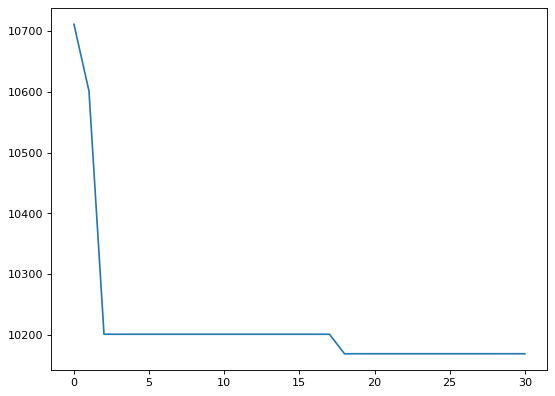

In [62]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
X = [logbook[i]['Generation'] for i in range(len(logbook))]
Y_road = [logbook[i]['min'][0] for i in range(len(logbook))]
Y_nav = [logbook[i]['min'][1] for i in range(len(logbook))]
plt.plot(X, Y_road)